In [23]:
import sys
# sys.path.append('/content/eth-capstone-treewater-deficit/src')
sys.path.append('/home/renku/work/eth-capstone-treewater-deficit/src')
# sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
import os
import glob 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from sklearn.preprocessing import StandardScaler
import treewater.utils as utils
# from treewater.utils import *

In [24]:

import importlib
importlib.reload(utils)

# check presence

print(hasattr(utils, "compute_recursive_predictions_fast_torch"))

True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set global random seed
seed = 66666
torch.manual_seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING

In [5]:
derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"
model_output_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/derived/model_outputs/"

# derived_path = "/content/eth-capstone-treewater-deficit/data"
# data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

# model_output_dir = '/content/eth-capstone-treewater-deficit/data/derived/model_outputs/'

# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
# model_output_dir = '/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/model_outputs/'

In [6]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [7]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [8]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [9]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [10]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [11]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

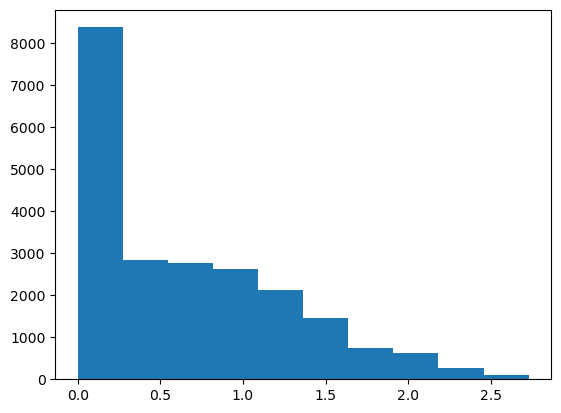

In [12]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [13]:
# Configure features

config = utils.FeatureConfig()
lag_n =7 # use 7 and smaller model size 
label_window_size = 7

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = utils.create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = utils.standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at, train_indexes = utils.get_dataset_NN_torch_with_indices(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at, val_indexes = utils.get_dataset_NN_torch_with_indices(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)





### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [14]:
batch_size = 256
lag_n = lag_n

### Autoregressive

In [15]:
# building datasets
batch_size = batch_size
# train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at

# ensure tensors are on CPU for DataLoader
if train_X_ts_at.device.type == "cuda":
    train_X_ts_at = train_X_ts_at.cpu(); train_day_feat_X_at = train_day_feat_X_at.cpu(); train_static_X_ts_at = train_static_X_ts_at.cpu(); train_y_at = train_y_at.cpu()

# Convert train_indexes to tensor if it's not already
if not isinstance(train_indexes, torch.Tensor):
    train_indexes = torch.tensor(train_indexes)

train_ds = TensorDataset(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, train_y_at, train_indexes)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

# validation dataset

if val_X_ts_at.device.type == "cuda":
    val_X_ts_at = val_X_ts_at.cpu(); val_day_feat_X_at = val_day_feat_X_at.cpu(); val_static_X_ts_at = val_static_X_ts_at.cpu(); val_y_at = val_y_at.cpu()

# Convert val_indexes to tensor if it's not already
if not isinstance(val_indexes, torch.Tensor):
    val_indexes = torch.tensor(val_indexes)

val_loader = DataLoader(TensorDataset(val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at, val_indexes),
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=2)


# create cross validate datasets 
# create cross validation dataframes 

train_val_datasets_at = utils.cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df, val_cv_df in train_val_datasets_at:
    X_tr, Xd_tr, Xs_tr, y_tr, train_indexes_cv = utils.get_dataset_NN_torch_with_indices(train_cv_df, feature_window_size=lag_n, 
                                                                                      label_window_size = label_window_size,
                                                                                      autoregressive=True, config=config)
    if X_tr.device.type == "cuda":
        X_tr = X_tr.cpu(); Xd_tr = Xd_tr.cpu(); Xs_tr = Xs_tr.cpu(); y_tr = y_tr.cpu()
    if not isinstance(train_indexes_cv, torch.Tensor):
        train_indexes_cv = torch.tensor(train_indexes_cv)
    tr_loader = DataLoader(TensorDataset(X_tr, Xd_tr, Xs_tr, y_tr, train_indexes_cv),
                           batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    X_va, Xd_va, Xs_va, y_va, val_indexes_cv = utils.get_dataset_NN_torch_with_indices(val_cv_df, feature_window_size=lag_n, 
                                                                                  label_window_size = label_window_size,
                                                                                  autoregressive=True, config=config)
    if X_va.device.type == "cuda":
        X_va = X_va.cpu(); Xd_va = Xd_va.cpu(); Xs_va = Xs_va.cpu(); y_va = y_va.cpu()
    if not isinstance(val_indexes_cv, torch.Tensor):
        val_indexes_cv = torch.tensor(val_indexes_cv)
    va_loader = DataLoader(TensorDataset(X_va, Xd_va, Xs_va, y_va, val_indexes_cv),
                           batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    cv_train_val_ds_at.append((tr_loader, va_loader))

### Build transformer architecture

In [16]:
# defined weighted MAE loss function with weight decay exponentially
def index_weighted_mae_exp_torch(H, decay=0.2):
    weights = torch.exp(-decay * torch.arange(H, dtype=torch.float32))
    weights = weights / weights.sum()

    def loss(y_pred, y_true):
        w = weights.to(y_pred.device, dtype=y_pred.dtype)
        return torch.mean(torch.sum(torch.abs(y_true - y_pred) * w, dim=1))
        #        ↑ sum over horizon, mean over batch
    return loss # do batch mean after summing over horizon

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class EncoderOnlyForecast(nn.Module):
    """
    Uses TransformerEncoderLayer + TransformerEncoder as the core architecture.
    Inputs:
      past_dynamic: (B, T, n_dyn)
      current_day_exog: (B, n_day)
      static: (B, n_static)
    Output:
      next-day twd: (B,)
    """
    def __init__(
        self,
        n_dyn: int,
        n_day: int,
        n_static: int,
        T: int = 13,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 32,
        dropout: float = 0.1,
        out_nonneg: bool = False,
    ):
        super().__init__()
        self.T = T
        self.out_nonneg = out_nonneg

        # project dynamic features -> d_model
        self.in_proj = nn.Linear(n_dyn, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max(T, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # IMPORTANT: we use (B, T, C)
            norm_first=True
            
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # combine with day exog + static
        self.day_mlp = nn.Sequential(
            nn.Linear(n_day, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(d_model + 4 + 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, past_dynamic, current_day_exog, static):
        # past_dynamic: (B, T, n_dyn)
        x = self.in_proj(past_dynamic)   # (B, T, d_model)
        x = self.pos(x)
        x = self.encoder(x)              # (B, T, d_model)

        # pool: last token (works well for fixed window)
        x_seq = x[:, -1, :]              # (B, d_model)

        x_day = self.day_mlp(current_day_exog)
        x_stat = self.static_mlp(static)

        z = torch.cat([x_seq, x_day, x_stat], dim=-1)
        y = self.head(z).squeeze(-1)

        if self.out_nonneg:
            y = F.linear(y) # using linear to allow negative outputs for log2 twd

        return y


### set up cross validation

In [17]:
model_factory = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=32,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# build a training loop

loss_fn = index_weighted_mae_exp_torch(H=label_window_size, decay=0.2)
optimizer = torch.optim.Adam(model_factory().parameters(), lr=1e-3/2)

rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = utils.cross_validate_transformer_rolling_loss(
    model_factory=model_factory,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


model_factory_2 = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=64,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)


rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2 = utils.cross_validate_transformer_rolling_loss(
    model_factory=model_factory_2,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting fold 1/4
Epoch 1/50


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4331, Train RMSE:0.5820, Val loss:0.4853, Val RMSE:0.7157
Epoch 2/50
Train loss:0.3939, Train RMSE:0.5117, Val loss:0.5514, Val RMSE:0.7649
Epoch 3/50
Train loss:0.4147, Train RMSE:0.5042, Val loss:0.4508, Val RMSE:0.6467
Epoch 4/50
Train loss:0.3173, Train RMSE:0.4489, Val loss:0.3845, Val RMSE:0.5541
Epoch 5/50
Train loss:0.3105, Train RMSE:0.4162, Val loss:0.3783, Val RMSE:0.5479
Epoch 6/50
Train loss:0.2955, Train RMSE:0.4002, Val loss:0.3733, Val RMSE:0.5467
Epoch 7/50
Train loss:0.2793, Train RMSE:0.3808, Val loss:0.3726, Val RMSE:0.5462
Epoch 8/50
Train loss:0.2494, Train RMSE:0.3502, Val loss:0.3518, Val RMSE:0.4693
Epoch 9/50
Train loss:0.2705, Train RMSE:0.3590, Val loss:0.3600, Val RMSE:0.5165
Epoch 10/50
Train loss:0.2477, Train RMSE:0.3232, Val loss:0.3517, Val RMSE:0.4938
Epoch 11/50
Train loss:0.2507, Train RMSE:0.3503, Val loss:0.3460, Val RMSE:0.4863
Epoch 12/50
Train loss:0.2205, Train RMSE:0.3185, Val loss:0.3563, Val RMSE:0.5117
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.6583, Train RMSE:0.8476, Val loss:0.4738, Val RMSE:0.6310
Epoch 2/50
Train loss:0.4908, Train RMSE:0.5840, Val loss:0.4543, Val RMSE:0.5756
Epoch 3/50
Train loss:0.4595, Train RMSE:0.5893, Val loss:0.4500, Val RMSE:0.5534
Epoch 4/50
Train loss:0.3989, Train RMSE:0.5227, Val loss:0.4062, Val RMSE:0.5194
Epoch 5/50
Train loss:0.3279, Train RMSE:0.4987, Val loss:0.4005, Val RMSE:0.5057
Epoch 6/50
Train loss:0.3442, Train RMSE:0.5160, Val loss:0.3980, Val RMSE:0.4984
Epoch 7/50
Train loss:0.3428, Train RMSE:0.4336, Val loss:0.3628, Val RMSE:0.4656
Epoch 8/50
Train loss:0.2829, Train RMSE:0.4066, Val loss:0.3348, Val RMSE:0.4357
Epoch 9/50
Train loss:0.2923, Train RMSE:0.3807, Val loss:0.3135, Val RMSE:0.4155
Epoch 10/50
Train loss:0.2546, Train RMSE:0.3525, Val loss:0.2785, Val RMSE:0.3936
Epoch 11/50
Train loss:0.2501, Train RMSE:0.3529, Val loss:0.2699, Val RMSE:0.3894
Epoch 12/50
Train loss:0.2331, Train RMSE:0.3340, Val loss:0.2685, Val RMSE:0.3791
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4860, Train RMSE:0.6341, Val loss:0.3727, Val RMSE:0.4702
Epoch 2/50
Train loss:0.3642, Train RMSE:0.4946, Val loss:0.3078, Val RMSE:0.4023
Epoch 3/50
Train loss:0.2919, Train RMSE:0.4028, Val loss:0.2221, Val RMSE:0.3417
Epoch 4/50
Train loss:0.2535, Train RMSE:0.3583, Val loss:0.2040, Val RMSE:0.3243
Epoch 5/50
Train loss:0.2408, Train RMSE:0.3422, Val loss:0.1948, Val RMSE:0.3137
Epoch 6/50
Train loss:0.2352, Train RMSE:0.3310, Val loss:0.1870, Val RMSE:0.3063
Epoch 7/50
Train loss:0.2225, Train RMSE:0.3318, Val loss:0.1871, Val RMSE:0.3064
Epoch 8/50
Train loss:0.2218, Train RMSE:0.3298, Val loss:0.1911, Val RMSE:0.3152
Epoch 9/50
Train loss:0.2211, Train RMSE:0.3277, Val loss:0.1839, Val RMSE:0.3077
Epoch 10/50
Train loss:0.2088, Train RMSE:0.3151, Val loss:0.1851, Val RMSE:0.3062
Epoch 11/50
Train loss:0.2285, Train RMSE:0.3180, Val loss:0.1752, Val RMSE:0.2898
Epoch 12/50
Train loss:0.2206, Train RMSE:0.3325, Val loss:0.1900, Val RMSE:0.3191
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4063, Train RMSE:0.5222, Val loss:0.2728, Val RMSE:0.3932
Epoch 2/50
Train loss:0.2842, Train RMSE:0.4076, Val loss:0.2545, Val RMSE:0.3602
Epoch 3/50
Train loss:0.2638, Train RMSE:0.3816, Val loss:0.2268, Val RMSE:0.3315
Epoch 4/50
Train loss:0.2459, Train RMSE:0.3634, Val loss:0.2296, Val RMSE:0.3395
Epoch 5/50
Train loss:0.2447, Train RMSE:0.3516, Val loss:0.2223, Val RMSE:0.3390
Epoch 6/50
Train loss:0.2310, Train RMSE:0.3400, Val loss:0.2279, Val RMSE:0.3438
Epoch 7/50
Train loss:0.2218, Train RMSE:0.3278, Val loss:0.2411, Val RMSE:0.3667
Epoch 8/50
Train loss:0.2240, Train RMSE:0.3303, Val loss:0.2167, Val RMSE:0.3342
Epoch 9/50
Train loss:0.2087, Train RMSE:0.3208, Val loss:0.2244, Val RMSE:0.3453
Epoch 10/50
Train loss:0.2112, Train RMSE:0.3205, Val loss:0.2056, Val RMSE:0.3175
Epoch 11/50
Train loss:0.2131, Train RMSE:0.3203, Val loss:0.2144, Val RMSE:0.3328
Epoch 12/50
Train loss:0.2073, Train RMSE:0.3243, Val loss:0.2046, Val RMSE:0.3176
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4600, Train RMSE:0.6622, Val loss:0.4413, Val RMSE:0.6571
Epoch 2/50
Train loss:0.3999, Train RMSE:0.5267, Val loss:0.6061, Val RMSE:0.8226
Epoch 3/50
Train loss:0.3352, Train RMSE:0.4919, Val loss:0.4316, Val RMSE:0.6646
Epoch 4/50
Train loss:0.3674, Train RMSE:0.5093, Val loss:0.5006, Val RMSE:0.7365
Epoch 5/50
Train loss:0.3086, Train RMSE:0.4266, Val loss:0.5298, Val RMSE:0.7622
Epoch 6/50
Train loss:0.2793, Train RMSE:0.4037, Val loss:0.4620, Val RMSE:0.6960
Epoch 7/50
Train loss:0.2928, Train RMSE:0.3345, Val loss:0.4759, Val RMSE:0.7004
Epoch 8/50
Train loss:0.2610, Train RMSE:0.3693, Val loss:0.3933, Val RMSE:0.6023
Epoch 9/50
Train loss:0.2296, Train RMSE:0.3322, Val loss:0.4101, Val RMSE:0.6346
Epoch 10/50
Train loss:0.1866, Train RMSE:0.2667, Val loss:0.4056, Val RMSE:0.6288
Epoch 11/50
Train loss:0.2285, Train RMSE:0.3220, Val loss:0.4244, Val RMSE:0.6578
Epoch 12/50
Train loss:0.2235, Train RMSE:0.3020, Val loss:0.4252, Val RMSE:0.6611
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4349, Train RMSE:0.5720, Val loss:0.3930, Val RMSE:0.5217
Epoch 2/50
Train loss:0.3534, Train RMSE:0.4574, Val loss:0.3670, Val RMSE:0.4636
Epoch 3/50
Train loss:0.2973, Train RMSE:0.3904, Val loss:0.3184, Val RMSE:0.4425
Epoch 4/50
Train loss:0.2671, Train RMSE:0.3718, Val loss:0.2704, Val RMSE:0.3806
Epoch 5/50
Train loss:0.2464, Train RMSE:0.3519, Val loss:0.2939, Val RMSE:0.4027
Epoch 6/50
Train loss:0.2552, Train RMSE:0.3536, Val loss:0.3063, Val RMSE:0.4041
Epoch 7/50
Train loss:0.2544, Train RMSE:0.3487, Val loss:0.2700, Val RMSE:0.3822
Epoch 8/50
Train loss:0.2298, Train RMSE:0.3315, Val loss:0.2663, Val RMSE:0.3753
Epoch 9/50
Train loss:0.2212, Train RMSE:0.3185, Val loss:0.2550, Val RMSE:0.3692
Epoch 10/50
Train loss:0.2011, Train RMSE:0.3052, Val loss:0.2507, Val RMSE:0.3797
Epoch 11/50
Train loss:0.2224, Train RMSE:0.3138, Val loss:0.2482, Val RMSE:0.3615
Epoch 12/50
Train loss:0.2088, Train RMSE:0.3134, Val loss:0.2439, Val RMSE:0.3629
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4318, Train RMSE:0.5938, Val loss:0.2881, Val RMSE:0.3994
Epoch 2/50
Train loss:0.3011, Train RMSE:0.4215, Val loss:0.2258, Val RMSE:0.3208
Epoch 3/50
Train loss:0.2699, Train RMSE:0.3697, Val loss:0.2015, Val RMSE:0.3211
Epoch 4/50
Train loss:0.2807, Train RMSE:0.3818, Val loss:0.2102, Val RMSE:0.3118
Epoch 5/50
Train loss:0.2404, Train RMSE:0.3519, Val loss:0.1915, Val RMSE:0.3145
Epoch 6/50
Train loss:0.2378, Train RMSE:0.3383, Val loss:0.1894, Val RMSE:0.3030
Epoch 7/50
Train loss:0.2187, Train RMSE:0.3304, Val loss:0.1810, Val RMSE:0.3010
Epoch 8/50
Train loss:0.2143, Train RMSE:0.3234, Val loss:0.1809, Val RMSE:0.2916
Epoch 9/50
Train loss:0.2131, Train RMSE:0.3198, Val loss:0.1832, Val RMSE:0.2919
Epoch 10/50
Train loss:0.1989, Train RMSE:0.3148, Val loss:0.2019, Val RMSE:0.3371
Epoch 11/50
Train loss:0.2100, Train RMSE:0.3208, Val loss:0.1804, Val RMSE:0.3034
Epoch 12/50
Train loss:0.1983, Train RMSE:0.3040, Val loss:0.1725, Val RMSE:0.2913
Epoch 13/50
Train loss:0

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4745, Train RMSE:0.6068, Val loss:0.3517, Val RMSE:0.4848
Epoch 2/50
Train loss:0.2965, Train RMSE:0.4128, Val loss:0.2800, Val RMSE:0.4096
Epoch 3/50
Train loss:0.2511, Train RMSE:0.3604, Val loss:0.2146, Val RMSE:0.3275
Epoch 4/50
Train loss:0.2289, Train RMSE:0.3375, Val loss:0.1948, Val RMSE:0.3076
Epoch 5/50
Train loss:0.2189, Train RMSE:0.3257, Val loss:0.1978, Val RMSE:0.3126
Epoch 6/50
Train loss:0.2164, Train RMSE:0.3163, Val loss:0.1943, Val RMSE:0.3126
Epoch 7/50
Train loss:0.2165, Train RMSE:0.3186, Val loss:0.2077, Val RMSE:0.3194
Epoch 8/50
Train loss:0.2203, Train RMSE:0.3294, Val loss:0.2369, Val RMSE:0.3629
Epoch 9/50
Train loss:0.2064, Train RMSE:0.3144, Val loss:0.1936, Val RMSE:0.3083
Epoch 10/50
Train loss:0.2032, Train RMSE:0.3078, Val loss:0.1999, Val RMSE:0.3093
Epoch 11/50
Train loss:0.1969, Train RMSE:0.3102, Val loss:0.1896, Val RMSE:0.3053
Epoch 12/50
Train loss:0.2136, Train RMSE:0.3141, Val loss:0.1877, Val RMSE:0.3047
Epoch 13/50
Train loss:0

[Text(1, 0, 'hidden size =32'), Text(2, 0, 'model size =64')]

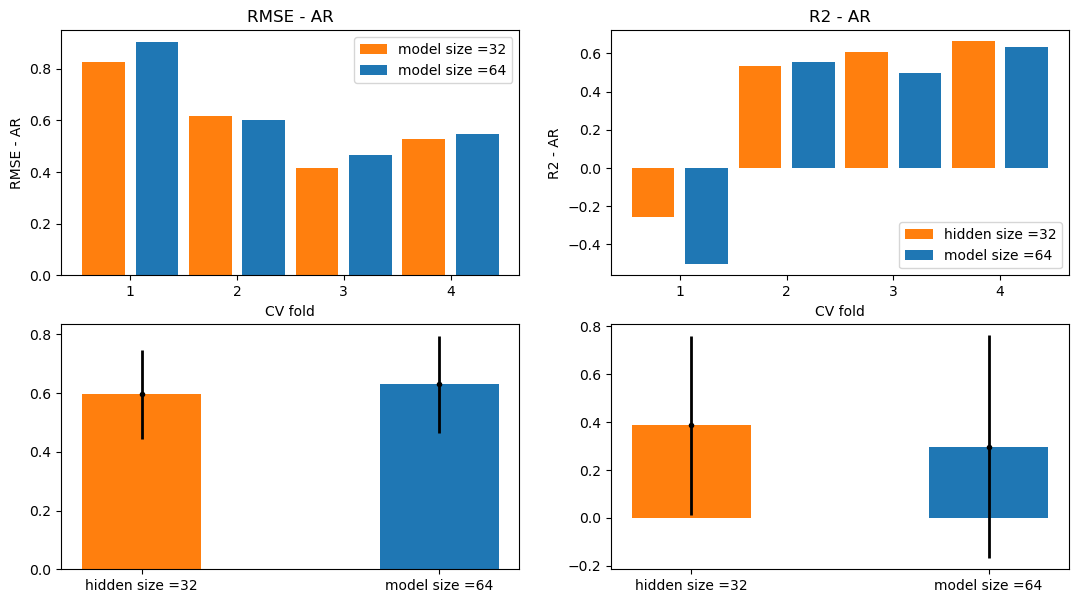

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['model size =32', 'model size =64'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =32', 'model size =64'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =32', 'model size =64'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =32', 'model size =64'])

In [19]:
# visualize CV results
for fold in range(len(rmses_cv_at)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at[fold]:.4f}, Recursive R2={r2s_cv_at[fold]:.4f}, 1-day R2={r2s_cv_1d_at[fold]:.4f}')

Fold 1: Recursive RMSE=0.8255, 1-day RMSE=0.6239, Recursive R2=-0.2558, 1-day R2=0.2876
Fold 2: Recursive RMSE=0.6157, 1-day RMSE=0.4156, Recursive R2=0.5344, 1-day R2=0.7725
Fold 3: Recursive RMSE=0.4136, 1-day RMSE=0.2144, Recursive R2=0.6067, 1-day R2=0.9046
Fold 4: Recursive RMSE=0.5266, 1-day RMSE=0.2979, Recursive R2=0.6629, 1-day R2=0.8949


In [21]:
model_size = 32

maybe test different model size?

In [26]:
# train baseline model on full training set with rolling loss
model_ar = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=1e-3/2)
loss_fn = index_weighted_mae_exp_torch(label_window_size, decay=0.2)


# writer = SummaryWriter(os.path.join(model_output_dir, f'transformer_ar{timestamp}'))
epoch_number = 0

history = {"train_loss": [], "train_rmse": [], "val_loss": [], "val_rmse": [],
           "p_tf": []}
best_vloss = float("inf")

EPOCHS = 80

best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ar.train(True)
    avg_loss, train_rmse = utils.train_one_epoch_rolling_loss(model_ar, epoch_number, train_loader, train_df_at, loss_fn, optimizer,
                                                        config,
                                           device=device, log_every=100)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_ar.eval()
    val_sse = 0.0
    val_n = 0   
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (X_dyn_val, X_day_val, X_static_val, vlabels, v_indexes) in enumerate(val_loader):
            v_indexes = v_indexes.numpy()
            voutputs_horizon, vtargets_horizon = utils.compute_recursive_predictions_fast_torch_training(
                model_ar,
                val_df_at.iloc[v_indexes[0,0]:v_indexes[-1, -1]+1, ],
                feature_window_size=X_dyn_val.shape[1],
                label_window_size=vlabels.shape[1],
                shift=1,
                batch_size = 256,
                config=config,
                rolling = True
            )
            voutputs_horizon = torch.as_tensor(voutputs_horizon).to(device)
            vtargets_horizon = torch.as_tensor(vtargets_horizon).to(device)
            vloss = loss_fn(voutputs_horizon, vtargets_horizon.to(device))
            running_vloss += vloss
            val_sse += F.mse_loss(voutputs_horizon, vtargets_horizon.to(device), reduction='sum').item()
            val_n += vtargets_horizon.numel()


    avg_vloss = running_vloss / (i + 1)
    avg_vloss_f = avg_vloss.item() if hasattr(avg_vloss, "item") else float(avg_vloss)

    val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
    print(f'Train loss:{avg_loss:.4f}, Train RMSE:{train_rmse:.4f}, Val loss:{avg_vloss:.4f}, Val RMSE:{val_rmse:.4f}')
    # Log the running loss averaged per batch
    # for both training and validation

    history["train_loss"].append(float(avg_loss))
    history["val_loss"].append(avg_vloss_f)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_output_dir, f'model_rolling_loss{epoch_number}')
        torch.save(model_ar.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4433, Train RMSE:0.5609, Val loss:0.2623, Val RMSE:0.3634
EPOCH 2:
Train loss:0.2829, Train RMSE:0.3987, Val loss:0.2238, Val RMSE:0.3228
EPOCH 3:
Train loss:0.2407, Train RMSE:0.3606, Val loss:0.2007, Val RMSE:0.3077
EPOCH 4:
Train loss:0.2369, Train RMSE:0.3460, Val loss:0.1852, Val RMSE:0.2996
EPOCH 5:
Train loss:0.2315, Train RMSE:0.3331, Val loss:0.1837, Val RMSE:0.2888
EPOCH 6:
Train loss:0.2292, Train RMSE:0.3311, Val loss:0.1769, Val RMSE:0.3027
EPOCH 7:
Train loss:0.2170, Train RMSE:0.3184, Val loss:0.1709, Val RMSE:0.2949
EPOCH 8:
Train loss:0.2052, Train RMSE:0.3123, Val loss:0.1644, Val RMSE:0.2889
EPOCH 9:
Train loss:0.2083, Train RMSE:0.3237, Val loss:0.1972, Val RMSE:0.3086
EPOCH 10:
Train loss:0.2033, Train RMSE:0.3181, Val loss:0.1785, Val RMSE:0.3040
EPOCH 11:
Train loss:0.2062, Train RMSE:0.3108, Val loss:0.1592, Val RMSE:0.2798
EPOCH 12:
Train loss:0.2079, Train RMSE:0.2994, Val loss:0.1591, Val RMSE:0.2855
EPOCH 13:
Train loss:0.1934, Train RMSE:0.2956

In [51]:
model_path

'/home/renku/work/eth-capstone-treewater-deficit/data/derived/model_outputs/model_rolling_loss64'

In [37]:
# predction on validation set
model_ar.eval()
model_best = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device) # initiate a new model
model_best.load_state_dict(torch.load(model_path))
preds = []
actuals = []
with torch.no_grad():
    for i, (X_dyn_val, X_day_val, X_static_val, vlabels, vindexes) in enumerate(val_loader):
        voutputs = model_best(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
        preds.append(voutputs.cpu().numpy().flatten())
        actuals.append(vlabels.cpu().numpy()[:,0].flatten())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


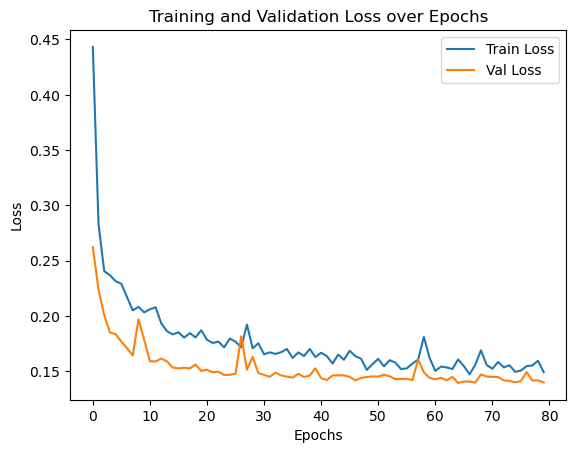

In [38]:
plt.plot(range(0, EPOCHS), history["train_loss"], label="Train Loss")
plt.plot(range(0, EPOCHS), history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

Text(0.5, 1.0, 'next day prediction - transformer (rolling loss)')

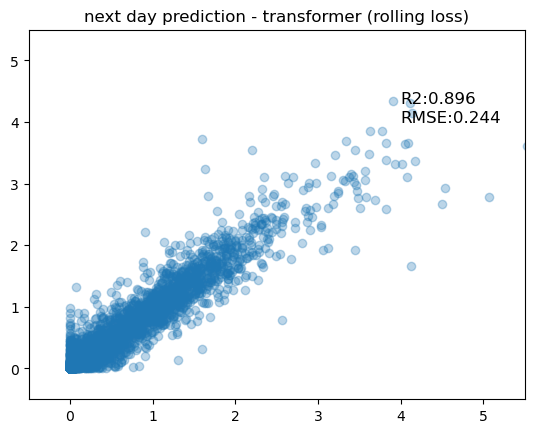

In [56]:
# next day prediction performance
rmse = root_mean_squared_error(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))
r2 = r2_score(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))

plt.scatter(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds), alpha=0.3)
plt.text(x=4, y = 4, s = f"RMSE:{rmse:.3f}", fontsize = 12)
plt.text(x= 4, y = 4.3, s=f"R2:{r2:.3f}", fontsize = 12)
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.title("next day prediction - transformer (rolling loss)")


In [42]:
y_pred_val_at, y_val_at = utils.compute_recursive_predictions_fast_torch(model_best.to(device), val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=128)

In [ ]:
plt.scatter( y_val_at,y_pred_val_at)

Recursive prediction on validation set - RMSE: 0.4231, R2: 0.7138


Text(0.5, 1.0, '7 day prediction - transformer (rolling loss)')

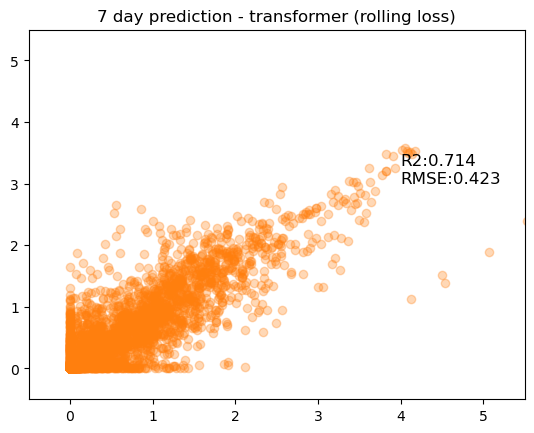

In [55]:
rmse_at= root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
r2_at = r2_score(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
print(f"Recursive prediction on validation set - RMSE: {rmse_at:.4f}, R2: {r2_at:.4f}")


plt.scatter(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at), alpha=0.3, color = "tab:orange")
plt.text(x=4, y = 3, s = f"RMSE:{rmse_at:.3f}", fontsize = 12)
plt.text(x= 4, y = 3.3, s=f"R2:{r2_at:.3f}", fontsize = 12)
plt.xlim(-0.5,5.5)
plt.ylim(-0.5, 5.5)
plt.title("7 day prediction - transformer (rolling loss)")

- performance appears more stable when model size is 64

In [92]:
model_size = 64

### Fine-tune model

In [114]:
# build a fresh model with identical architecture
model_FT = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = utils.cross_validation_torch_FT(
    model_FT,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    n_epochs=50,
    device = device,
    if_log = True
    
)



/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Training fold 1/4
Epoch 1/50
  Train Loss: 0.0425, Train RMSE: 0.2919
  Validation Loss: 0.0414, Validation RMSE: 0.2891
Epoch 2/50
  Train Loss: 0.0368, Train RMSE: 0.2715
  Validation Loss: 0.0417, Validation RMSE: 0.2904
Epoch 3/50
  Train Loss: 0.0336, Train RMSE: 0.2592
  Validation Loss: 0.0493, Validation RMSE: 0.3159
Epoch 4/50
  Train Loss: 0.0318, Train RMSE: 0.2522
  Validation Loss: 0.0530, Validation RMSE: 0.3278
Epoch 5/50
  Train Loss: 0.0299, Train RMSE: 0.2444
  Validation Loss: 0.0545, Validation RMSE: 0.3327
Epoch 6/50
  Train Loss: 0.0286, Train RMSE: 0.2393
  Validation Loss: 0.0610, Validation RMSE: 0.3520
Epoch 7/50
  Train Loss: 0.0276, Train RMSE: 0.2348
  Validation Loss: 0.0625, Validation RMSE: 0.3565
Epoch 8/50
  Train Loss: 0.0265, Train RMSE: 0.2303
  Validation Loss: 0.0532, Validation RMSE: 0.3285
Epoch 9/50
  Train Loss: 0.0255, Train RMSE: 0.2257
  Validation Loss: 0.0508, Validation RMSE: 0.3209
Epoch 10/50
  Train Loss: 0.0248, Train RMSE: 0.2225
  

In [118]:
# visualize CV results
for fold in range(len(rmses_cv_at_finetune)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at_finetune[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at_finetune[fold]:.4f}, Recursive R2={r2s_cv_at_finetune[fold]:.4f}, 1-day R2={r2s_cv_1d_at_finetune[fold]:.4f}')

Fold 1: Recursive RMSE=0.9149, 1-day RMSE=0.3767, Recursive R2=-0.5077, 1-day R2=0.7336
Fold 2: Recursive RMSE=0.8271, 1-day RMSE=0.2859, Recursive R2=0.1734, 1-day R2=0.8968
Fold 3: Recursive RMSE=0.5174, 1-day RMSE=0.1411, Recursive R2=0.3031, 1-day R2=0.9599
Fold 4: Recursive RMSE=0.9167, 1-day RMSE=0.3135, Recursive R2=-0.0152, 1-day R2=0.8819


In [117]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = utils.build_autoregressive_training_data_fast_torch(
    model=model_FT,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
    device = device
)

train_ds_ar = TensorDataset(X_dyn_ar.cpu(), X_day_ar.cpu(), X_static_ar.cpu() , y_ar.cpu())
train_loader_ar = DataLoader(train_ds_ar,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)



In [173]:
# train final model on the full training set with AR-corrupted data
E2 = 60


# build a fresh model with identical architecture
model_FT_all = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT_all.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

# now fine-tune on AR-corrupted dataset
optimizer = torch.optim.Adam(model_FT_all.parameters(), lr=1e-3/2)
model_FT_all, history_FT_all = utils.train_transformer(
    model_FT_all, train_loader_ar, val_loader, loss_fn, optimizer, n_epochs=E2, device=device
    
)

Epoch 1/60


  batch 100 loss: 0.0645
  Train Loss: 0.0630, Train RMSE: 0.3574
  Validation Loss: 0.0381, Validation RMSE: 0.2788
Epoch 2/60
  batch 100 loss: 0.0469
  Train Loss: 0.0468, Train RMSE: 0.3061
  Validation Loss: 0.0386, Validation RMSE: 0.2808
Epoch 3/60
  batch 100 loss: 0.0422
  Train Loss: 0.0421, Train RMSE: 0.2905
  Validation Loss: 0.0337, Validation RMSE: 0.2623
Epoch 4/60
  batch 100 loss: 0.0404
  Train Loss: 0.0403, Train RMSE: 0.2842
  Validation Loss: 0.0426, Validation RMSE: 0.2951
Epoch 5/60
  batch 100 loss: 0.0382
  Train Loss: 0.0378, Train RMSE: 0.2753
  Validation Loss: 0.0364, Validation RMSE: 0.2726
Epoch 6/60
  batch 100 loss: 0.0368
  Train Loss: 0.0368, Train RMSE: 0.2716
  Validation Loss: 0.0390, Validation RMSE: 0.2824
Epoch 7/60
  batch 100 loss: 0.0350
  Train Loss: 0.0349, Train RMSE: 0.2642
  Validation Loss: 0.0395, Validation RMSE: 0.2840
Epoch 8/60
  batch 100 loss: 0.0348
  Train Loss: 0.0349, Train RMSE: 0.2644
  Validation Loss: 0.0365, Validation 

In [174]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = utils.compute_recursive_predictions_fast_torch(model_FT_all, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [175]:
r2_FT = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

r2: 0.4464671074580351
 rmse: 0.5953753335889516


### scheduled sampling - train model

cross validation - implement cross validation

In [ ]:
# build a fresh model with identical architecture
n_epochs = 50
model_at_ar_cv = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.load_state_dict(model_ar.state_dict())

rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = utils.cross_validation_torch_scheduled(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    n_epochs=n_epochs,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True,
    device = device,
    if_log = True)


# key is too modify  build_autoregressive_training_data_fast_torch to allow return label window size 

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Training fold 1/4
Epoch 1/50
  Train Loss: 0.0083, Train RMSE: 0.1292, p_tf: 1.0000
  Validation Loss: 0.0171, Validation RMSE: 0.1859
Epoch 2/50
  Train Loss: 0.0073, Train RMSE: 0.1205, p_tf: 1.0000
  Validation Loss: 0.0119, Validation RMSE: 0.1548
Epoch 3/50
  Train Loss: 0.0074, Train RMSE: 0.1216, p_tf: 1.0000
  Validation Loss: 0.0124, Validation RMSE: 0.1580
Epoch 4/50
  Train Loss: 0.0072, Train RMSE: 0.1200, p_tf: 0.8714
  Validation Loss: 0.0118, Validation RMSE: 0.1544
Epoch 5/50
  Train Loss: 0.0067, Train RMSE: 0.1155, p_tf: 0.8714
  Validation Loss: 0.0154, Validation RMSE: 0.1762
Epoch 6/50
  Train Loss: 0.0068, Train RMSE: 0.1170, p_tf: 0.8714
  Validation Loss: 0.0167, Validation RMSE: 0.1838
Epoch 7/50
  Train Loss: 0.0065, Train RMSE: 0.1142, p_tf: 0.8714
  Validation Loss: 0.0109, Validation RMSE: 0.1481
Epoch 8/50
  Train Loss: 0.0067, Train RMSE: 0.1157, p_tf: 0.8714
  Validation Loss: 0.0106, Validation RMSE: 0.1465
Epoch 9/50
  Train Loss: 0.0072, Train RMSE: 0

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120


# init model with same architecture
model_ss = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)
# copy weights from model_at (teacher-forced trained model)
model_ss.load_state_dict(model_ar.state_dict())

optimizer = torch.optim.Adam(model_ss.parameters(), lr=1e-3/2)

model_ss_best, history_at_ar = utils.train_transformer_scheduled(model_ss, train_df_at, val_loader, lag_n, 
                                                          config, batch_size, 
                                                            loss_fn, optimizer, n_epochs=num_epochs,
                                                            p_min = 0.1, warmup_epochs=3, frac_decay = 0.9, 
                                                            epoch_per_step = 15,
                                                            slow_decay = True,
                                                            device=device)



/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/120
  batch 100 loss: 0.0078
  Train Loss: 0.0078, Train RMSE: 0.1254, p_tf: 1.0000
  Validation Loss: 0.0106, Validation RMSE: 0.1468
Epoch 2/120
  batch 100 loss: 0.0074
  Train Loss: 0.0074, Train RMSE: 0.1217, p_tf: 1.0000
  Validation Loss: 0.0113, Validation RMSE: 0.1517
Epoch 3/120
  batch 100 loss: 0.0076
  Train Loss: 0.0076, Train RMSE: 0.1231, p_tf: 1.0000
  Validation Loss: 0.0114, Validation RMSE: 0.1528
Epoch 4/120
  batch 100 loss: 0.0081
  Train Loss: 0.0080, Train RMSE: 0.1264, p_tf: 0.8714
  Validation Loss: 0.0111, Validation RMSE: 0.1504
Epoch 5/120
  batch 100 loss: 0.0078
  Train Loss: 0.0078, Train RMSE: 0.1248, p_tf: 0.8714
  Validation Loss: 0.0107, Validation RMSE: 0.1477
Epoch 6/120
  batch 100 loss: 0.0080
  Train Loss: 0.0080, Train RMSE: 0.1262, p_tf: 0.8714
  Validation Loss: 0.0109, Validation RMSE: 0.1492
Epoch 7/120
  batch 100 loss: 0.0078
  Train Loss: 0.0079, Train RMSE: 0.1255, p_tf: 0.8714
  Validation Loss: 0.0106, Validation RMSE: 0.1470

maybe adjust loss function?

In [161]:
# save training history
train_his_path = os.path.join(derived_path,"derived", "training_history", "history_tranformer_scheduled_sampling_log.npy")
np.save(train_his_path, history_ar_at)

# save best model
model_path_best = os.path.join(model_output_dir, f'model_transformer_scheduled.pth')
torch.save(model_ss_best.state_dict(), model_path_best)



In [164]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= utils.compute_recursive_predictions_fast_torch(model_ss_best, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_ar),utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_ar), utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: 0.5830891335364017
 rmse: 0.5167026974092986


In [176]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (model size = 32)'] *4 + ['teacher_forcing (model size = 64)'] *4 + ['fine_tuned (model size = 64)'] *4 + ['scheduled_sampling (model size = 64)'] *4,    
    "cv_fold"  : [i for i in range(1, len(rmses_cv_at_ar) + 1)] *4,
    # "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

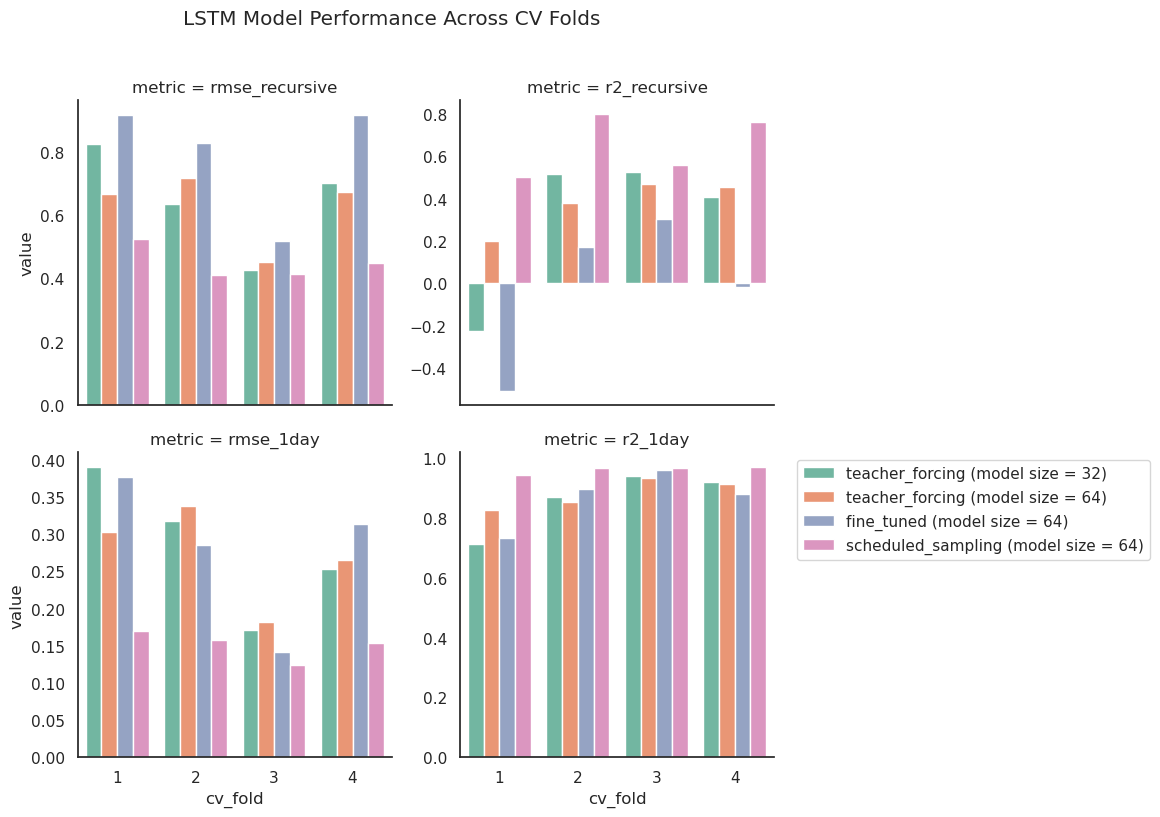

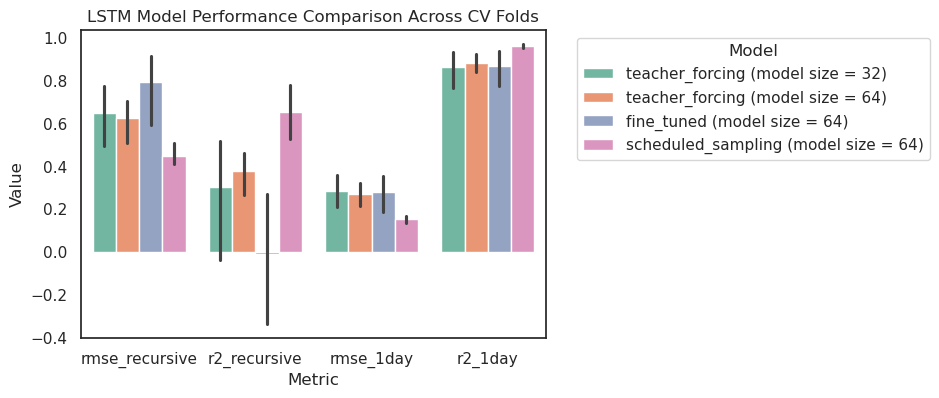

In [177]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/tmp/ipykernel_975/3269729888.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_975/3269729888.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_975/3269729888.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_975/3269729888.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax

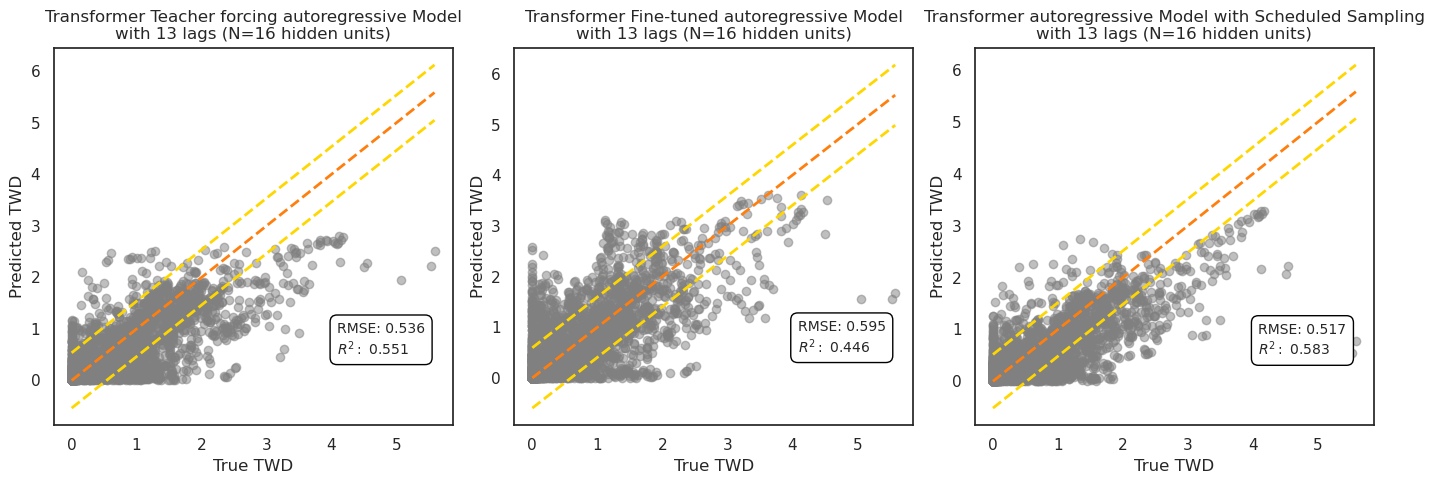

In [199]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.numpy()
    return np.asarray(x)

model_type = "Transformer"
y_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"{model_type} Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"{model_type} Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"{model_type} autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

trained with logged values

why the performance is so bad ..
- try the same on ridge regression?
- pick the best model in different training strategy?